# 3.  Prekybinės strategijos parašymas *Python* aplinkoje
### Prieškryptinė strategija (mean reversion) - Bollinger Bands indikatorius

https://library.tradingtechnologies.com/trade/chrt-ti-bollinger-bands.html

Sukuriama prekybos sistema bei simuliacija, įtraukiant visus prekybos kaštus, taip pat atliekama optimizacija.

Atliekamas optimizavimas, randami geriausi parametrų rinkiniai.

**Darbą atliko:** Evelina Vaitkevičiūtė, DM 3k. 1gr.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import yfinance as yf

data = yf.download("META", start="2014-01-01", end="2024-01-01")
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-01-02  54.830002  55.220001  54.189999  54.709999  54.652012  43195500
2014-01-03  55.020000  55.650002  54.529999  54.560001  54.502174  38246200
2014-01-06  54.419998  57.259998  54.049999  57.200001  57.139374  68852600
2014-01-07  57.700001  58.549999  57.220001  57.919998  57.858608  77207400
2014-01-08  57.599998  58.410000  57.230000  58.230000  58.168282  56682400


In [ ]:
import pandas as pd

def read_data(file_name, notebook_path='/content/gdrive/MyDrive/Finansinis_intelektas/ND3/'):
    file_path = notebook_path + file_name
    data_pd = pd.read_csv(file_path)
    data_pd["Date"] = pd.to_datetime(data_pd["Date"])
    data_pd = data_pd.set_index("Date")
    print(data_pd.dtypes)
    return data_pd

data_pd = read_data('META.csv')
print(data_pd)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-01-02   54.830002   55.220001   54.189999   54.709999   54.652012   
2014-01-03   55.020000   55.650002   54.529999   54.560001   54.502174   
2014-01-06   54.419998   57.259998   54.049999   57.200001   57.139374   
2014-01-07   57.700001   58.549999   57.220001   57.919998   57.858608   
2014-01-08   57.599998   58.410000   57.230000   58.230000   58.168282   
...                ...         ...         ...         ...         ...   
2023-12-22  355.579987  357.200012  351.220001  353.390015  353.015472   
2023-12-26  354.989990  356.980011  353.450012  354.829987  354.453918   
2023-12-27  356.070007  359.000000  355.309998  357.829987  357.450714   
2023-12-28  359.700012  361.899994  357.809998

In [ ]:
df = data_pd[["Close"]].copy()
df

,Close
Date,
2014-01-02,54.709999
2014-01-03,54.560001
2014-01-06,57.200001
2014-01-07,57.919998
2014-01-08,58.230000
...,...
2023-12-22,353.390015
2023-12-26,354.829987
2023-12-27,357.829987


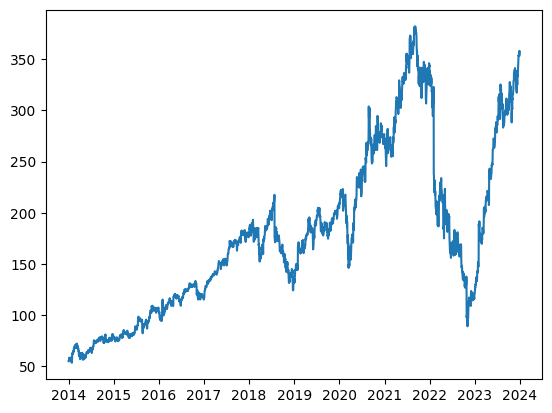

In [ ]:
plt.plot(data_pd[["Close"]])

## Strategijos parašymas Python

Prieškryptinė strategija (mean reversion). Bollinger: kai kaina pasiekia apatinį band -> pirkti; kaina pasiekia viršutinį band -> parduoti;

Bollinger galima realizuoti pagal trendą ir prieš trendą.

Kol kaina vienoje vietoje juda - tol sistema pelninga; kai rinka pradeda eiti į trendą turime nuostolį

Pirminis strategijos variantas:

In [ ]:
def bollinger_bands_strategy(df, window, std):
  df = df.copy()
  price_column = "Close"

  df['ma_20'] = df[price_column].rolling(window=window).mean()
  df['std_dev'] = df[price_column].rolling(window=window).std()
  df['upper_bollinger'] = df['ma_20'] + (std * df['std_dev'])
  df['lower_bollinger'] = df['ma_20'] - (std * df['std_dev'])

  buys = []
  sells = []
  open_pos = False  # Pozicija - uzdara ar atvira

  for i in range(len(df)):
      if df['lower_bollinger'].iloc[i] > df['Close'].iloc[i]:
          if not open_pos:
              buys.append(i)
              open_pos = True
      elif df['upper_bollinger'].iloc[i] < df['Close'].iloc[i]:
          if open_pos:
              sells.append(i)
              open_pos = False

  return df, buys, sells

window = 20  # lango (window) dydis
std=2
df_modified, buys, sells = bollinger_bands_strategy(df.copy(), window, std)

print("Pirkimai:", buys)
print("Pardavimai:", sells)


Pirkimai: [55, 128, 195, 261, 333, 411, 490, 615, 716, 939, 985, 1033, 1149, 1362, 1498, 1530, 1632, 1756, 1942, 2192, 2471]
Pardavimai: [99, 139, 228, 284, 356, 456, 521, 647, 759, 963, 1008, 1086, 1278, 1481, 1502, 1592, 1656, 1812, 2151, 2266, 2484]


Antrinis variantas, papildžius su stop loss

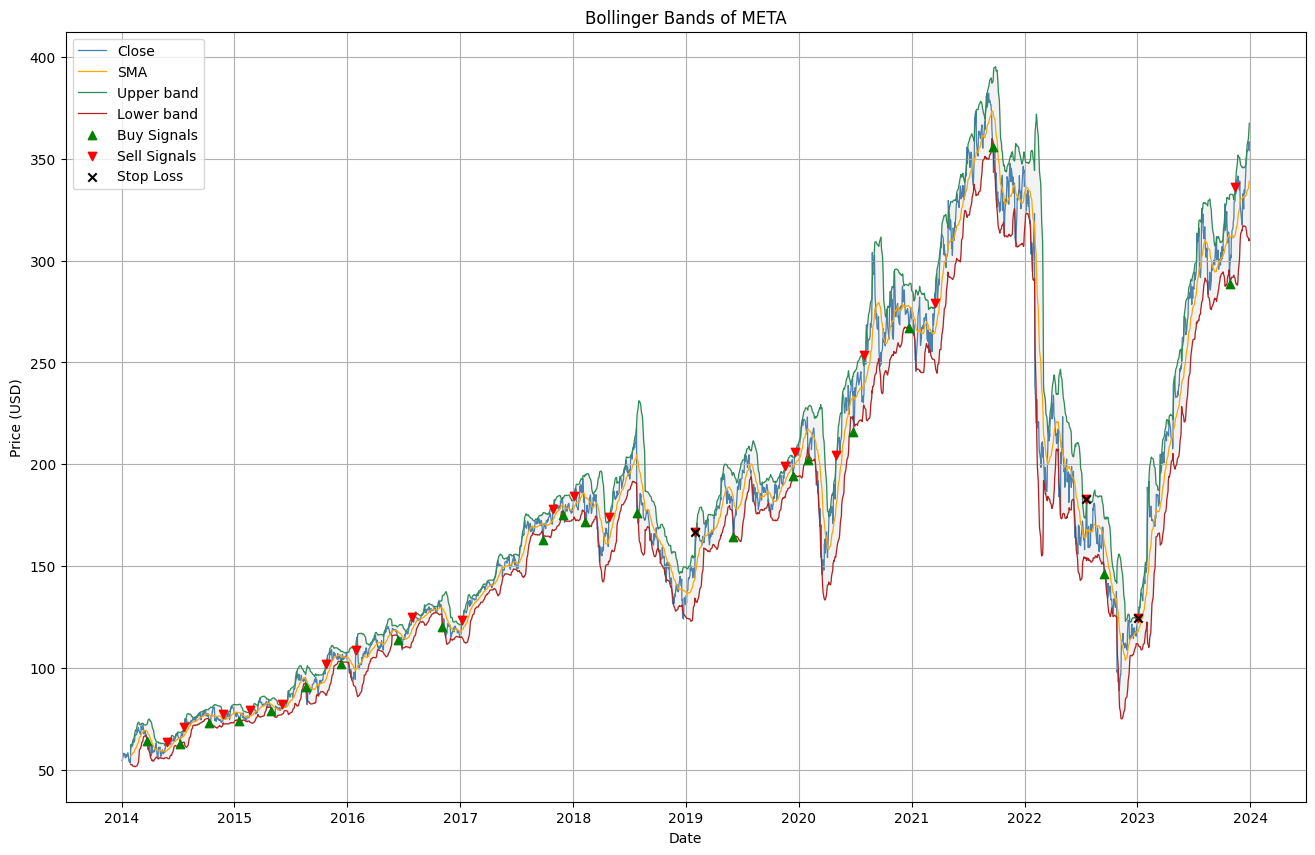

In [ ]:
def bollinger_bands_strategy(df, window, stop_loss_percent):
    df = df.copy()
    price_column = "Close"

    df['ma_20'] = df[price_column].rolling(window=window).mean()
    df['std'] = df[price_column].rolling(window=window).std()
    df['upper_bollinger'] = df['ma_20'] + (2 * df['std'])
    df['lower_bollinger'] = df['ma_20'] - (2 * df['std'])

    buys = []
    sells = []
    stop_loss_points = []  # stop-loss taskai

    open_pos = False  # Pozicija - uzdara ar atvira

    for i in range(len(df)):
        if df['lower_bollinger'].iloc[i] > df['Close'].iloc[i]:
            if not open_pos:
                buys.append(i)
                open_pos = True
                # Calculate stop loss price
                stop_loss_price = df['Close'].iloc[i] * (1 - stop_loss_percent)
        elif df['upper_bollinger'].iloc[i] < df['Close'].iloc[i]:
            if open_pos:
                # Check if the stop loss condition is met
                if df['Close'].iloc[i] <= stop_loss_price:
                    sells.append(i)
                    open_pos = False
                    stop_loss_points.append((df.index[i], df['Close'].iloc[i]))  # Append stop-loss point
                else:
                    sells.append(i)
                    open_pos = False

    stop_loss_points = pd.DataFrame(stop_loss_points, columns=['Date', 'Close'])  # Convert to DataFrame

    return df, buys, sells, stop_loss_points

def plot_bollinger_bands(df, buys, sells, stop_loss_points):
    plt.figure(figsize=(16, 10))
    plt.plot(df.index.values, df['Close'].values, label='Close', color='steelblue', lw=0.9, zorder=1)
    plt.plot(df.index.values, df['ma_20'].values, label='SMA', color='orange', lw=0.9, zorder=2)
    plt.plot(df.index.values, df['upper_bollinger'].values, label='Upper band', color='seagreen', lw=0.9, zorder=2)
    plt.plot(df.index.values, df['lower_bollinger'].values, label='Lower band', color='firebrick', lw=0.9, zorder=2)
    plt.scatter(df.iloc[buys].index, df.iloc[buys].Close, marker='^', color='green', label='Buy Signals', zorder=3)
    plt.scatter(df.iloc[sells].index, df.iloc[sells].Close, marker='v', color='red', label='Sell Signals', zorder=3)

    plt.scatter(stop_loss_points['Date'], stop_loss_points['Close'], marker='x', color='black', label='Stop Loss', zorder=4)

    plt.fill_between(df.index, df.upper_bollinger, df.lower_bollinger, color='grey', alpha=0.1) # uzpildymas tarp juostu

    # Customize the plot
    plt.title('Bollinger Bands of META')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

df_modified, buys, sells, stop_loss_points = bollinger_bands_strategy(df, window=20, stop_loss_percent=0.05)
plot_bollinger_bands(df_modified, buys, sells, stop_loss_points)


## Galutinis strategijos variantas

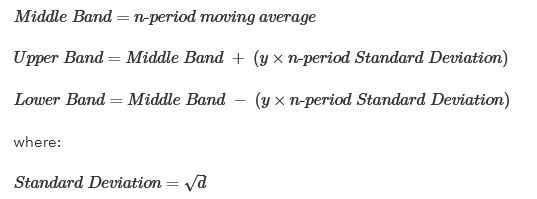

In [ ]:
def calculate_bollinger_bands(df, window, std_dev, transaction_costs):
    price_column = "Close"

    df['ma_20'] = df[price_column].rolling(window=window).mean()
    df['std'] = df[price_column].rolling(window=window).std()
    df['upper_band'] = df['ma_20'] + (std_dev * df['std'])
    df['lower_band'] = df['ma_20'] - (std_dev * df['std'])

    df['position_in_future'] = 0
    df.loc[df['Close'] < df['lower_band'], 'position_in_future'] = 1 # pirkimas
    df.loc[df['Close'] > df['upper_band'], 'position_in_future'] = -1 # pardavimas

    df['position'] = df['position_in_future'].shift(1) # perstumia -> kad atiktiktu pozicija kuri buvo praejusia
    df.loc[df.index[0], 'position'] = 0 # nustato pozicija pirmaja diena i 0 -> nera ankstesnes pozicijos, kur butu galima perstumti
    df['position_change'] = df['position_in_future'] != df['position'] # tikrinama, ar esama pozicija sutampa su ankstesnes dienos

    n = 2 # pirkimo ir pardavimo sandoriu kastai
    df['transaction_costs'] = df['position_change'] * transaction_costs * n # sandoriu kastai

    df['price_change'] = df['Close'].diff(1) # kainu pokytis nuo praejusios dienos
    df.loc[df.index[0], 'price_change'] = 0 # kainos pokytis pirmaja diena nustatomas i 0

    # df['Returns'] = df['Close'].pct_change() # Alternatyva

    df['profit_from_position'] = df['position'] * df['price_change'] # kainos pokytis * pozicija
    df['total_profit'] = df['transaction_costs'] + df['profit_from_position']

    return df


def determine_trades(df, stop_loss):
    flag_buy = False  # kintamasis ar pries tai jau yra igyta pozicija
    trades = [] # saugomi signalai
    for idx, day in df.iterrows(): # idx - indeksas; day - eilutes duomenys
        if (day['position_in_future'] == 1) and (not flag_buy): # jei pozicija yra 1 ir anksciau neivykdytas pirkimas -> signalas pirkti
            signal = 1
            flag_buy = True  # pazymima kad buvo atliktas pirkimas
            buy_price = day['Close'] # pirkimo kaina
            stop_loss_price = buy_price * (1 - stop_loss) # procentine suma sumazinta nuo pirkimo kainos
        elif (day['position_in_future'] == -1) and flag_buy:
            if day['Close'] <= stop_loss_price: # dab. kaina mazesne/lygi uz stop loss kaina
                signal = -2  # taip -> signalas parduoti su stop loss signalu (-2)
            else:
                signal = -1 # pardavimas
            flag_buy = False # pazymima kad buvo atliktas pardavimas
        else:
            signal = 0
        trades.append(signal)

    df['position_signal'] = trades
    return df


df = data_pd[['Close']].copy()

window = 20
num_std_dev = 2
transaction_costs = -0.01

rez = calculate_bollinger_bands(df, window, num_std_dev, transaction_costs)

stop_loss = 0.02  # 2% stop-loss
df = determine_trades(df, stop_loss)


In [ ]:
df.tail(40)

,Close,ma_20,std,upper_band,lower_band,position_in_future,position,position_change,transaction_costs,price_change,profit_from_position,total_profit,position_signal
Date,,,,,,,,,,,,,
2023-11-02,310.869995,312.184999,10.192975,332.570949,291.799049,0,0.0,False,-0.00,-0.980011,-0.000000,-0.000000,0
2023-11-03,314.600006,312.143500,10.180750,332.505001,291.781999,0,0.0,False,-0.00,3.730011,0.000000,0.000000,0
2023-11-06,315.799988,312.015500,10.114355,332.244210,291.786790,0,0.0,False,-0.00,1.199982,0.000000,0.000000,0
2023-11-07,318.820007,311.864500,9.981636,331.827772,291.901229,0,0.0,False,-0.00,3.020019,0.000000,0.000000,0
2023-11-08,319.779999,311.462500,9.453133,330.368767,292.556234,0,0.0,False,-0.00,0.959992,0.000000,0.000000,0
2023-11-09,320.549988,311.281999,9.229749,329.741497,292.822501,0,0.0,False,-0.00,0.769989,0.000000,0.000000,0
2023-11-10,328.769989,311.985999,10.007576,332.001151,291.970846,0,0.0,False,-0.00,8.220001,0.000000,0.000000,0
2023-11-13,329.190002,312.387999,10.542263,333.472525,291.303473,0,0.0,False,-0.00,0.420013,0.000000,0.000000,0
2023-11-14,336.309998,313.003499,11.565588,336.134674,289.872323,-1,0.0,True,-0.02,7.119996,0.000000,-0.020000,-1


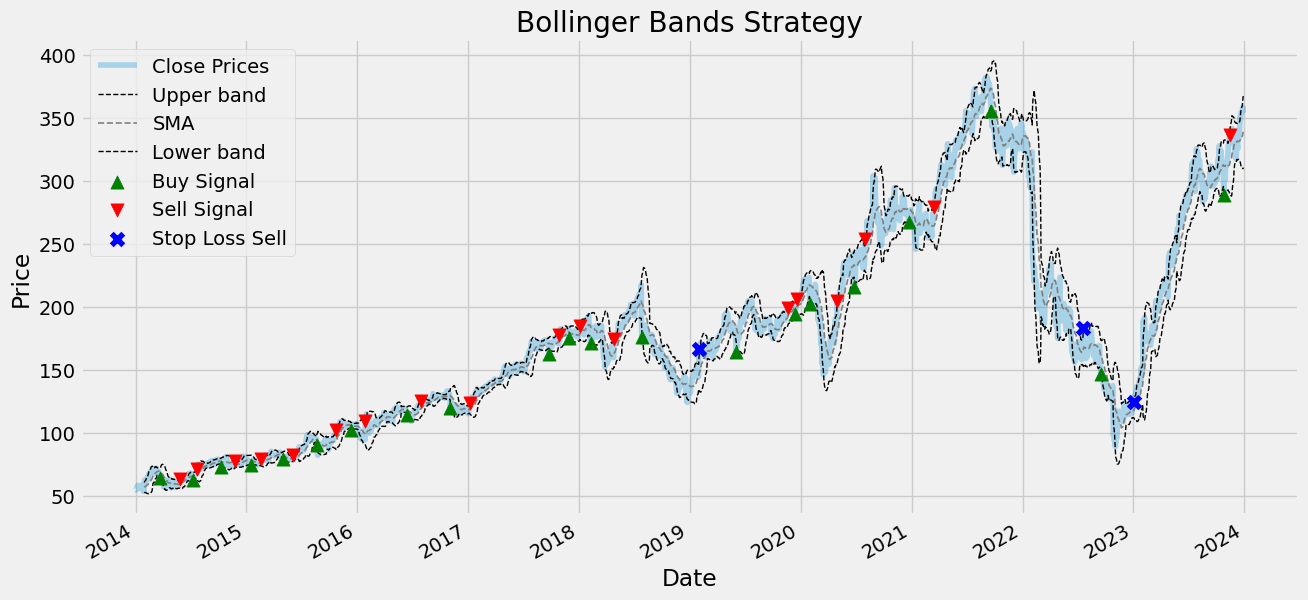

In [ ]:
# Grafinis vaizdavimas
def plot_bollinger_bands(df):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(14, 7))

    df['Close'].plot(label='Close Prices', alpha=0.3)
    df['upper_band'].plot(label='Upper band', linestyle='--', linewidth=1, color='black')
    df['ma_20'].plot(label='SMA', linestyle='--', linewidth=1.2, color='grey')
    df['lower_band'].plot(label='Lower band', linestyle='--', linewidth=1, color='black')

    plt.scatter(df.index[df['position_signal'] == 1], df['Close'][df['position_signal'] == 1], marker='^', color='g', label='Buy Signal', s=90, zorder=3)
    plt.scatter(df.index[df['position_signal'] == -1], df['Close'][df['position_signal'] == -1], marker='v', color='r', label='Sell Signal', s=90, zorder=3)
    plt.scatter(df.index[df['position_signal'] == -2], df['Close'][df['position_signal'] == -2], marker='x', color='b', label='Stop Loss Sell', s=70, zorder=3)

    plt.title('Bollinger Bands Strategy')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_bollinger_bands(df)


## Optimizavimas

Pilnas perrinkimas (brute force) - išbandoma visų parametrų visos kombinacijos ir ieškoma su kuriomis jis duoda geriausią rezultatą pagal numatytą kriterijų - kuo geresnis būtų sharpe santykis

Atsitiktinis badymas (random) - kai pilnas perrinkimas neįmanomas, pvz. yra milijonas kombinacijų ir galima bandyti daug bandymų, atsitiktinai parenkant parametrus



Best parameters for maximum Sharpe ratio:
{'window': 27, 'std_dev': 2, 'transaction_costs': 0.01}
Sharpe Ratio (Optimized): 0.7324389039180638
Sharpe Ratio (Non-Optimized): 0.6663182384227005


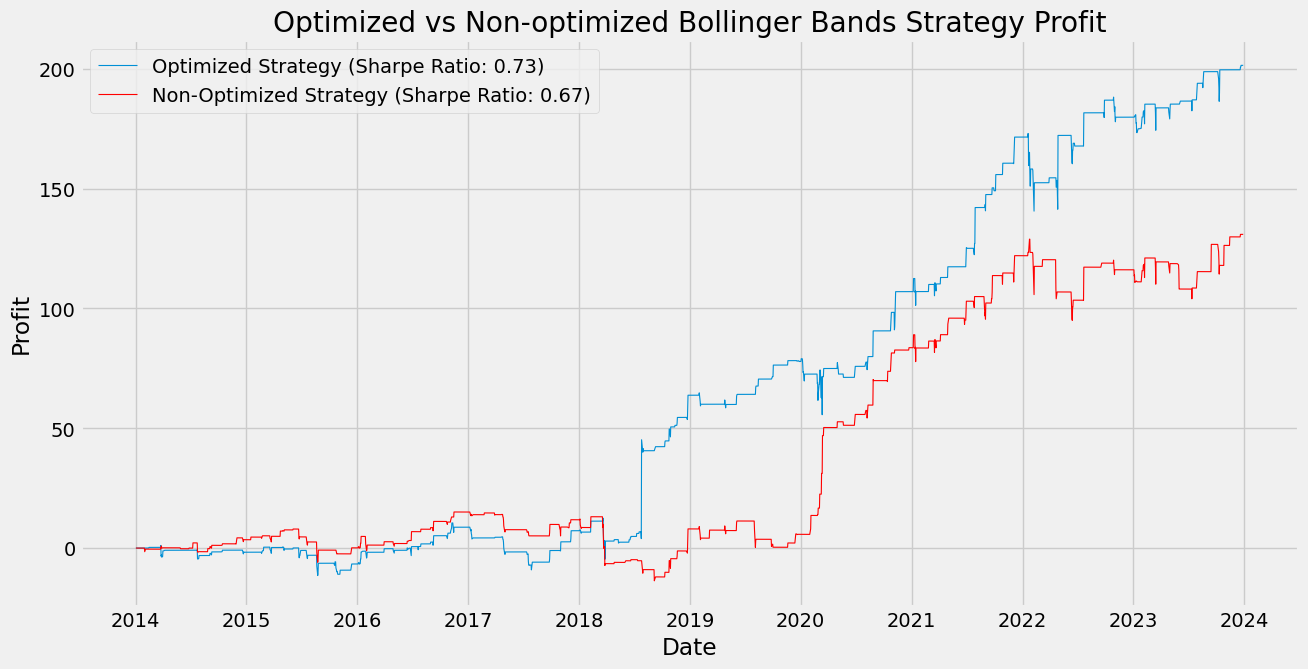

In [ ]:
pd.set_option('mode.chained_assignment', None)

# Sharpe santykis
def calculate_sharpe_ratio(returns, N=252): # N - dienu skaicius per metus per kurias prekiaujama (pagal nutylejima)
    sharpe_ratio = np.sqrt(N) * (returns.mean() / returns.std())
    return sharpe_ratio

# Parametru reziai brute force optimizavimui
window_range = range(27, 31, 5)
std_dev_range = [1, 1.5, 2, 2.5, 3]
transaction_costs_range = [-0.01, -0.005, 0, 0.005, 0.01]

best_sharpe_ratio = -np.inf # saugomas geriausas Sharpe santykis
optimal_params = {} # kintamasis saugantis optimalius parametrus

# Brute force optimizavimas
for window in window_range:
    for std_dev in std_dev_range:
        for transaction_costs in transaction_costs_range:
            df = data_pd[['Close']].copy()
            rez = calculate_bollinger_bands(df, window, std_dev, transaction_costs)
            df = determine_trades(df, stop_loss)  # prekybos operacijos su nustatytais stop-loss
            cumulative_profit = df['total_profit'].cumsum() # pelnas (kumuliatyvus)
            returns = df['total_profit']  # Returns are the daily profits
            sharpe_ratio = calculate_sharpe_ratio(returns)  # Sharpe santykis
            if sharpe_ratio > best_sharpe_ratio: # nustatoma ar naujai rastas Sharpe santykis yra geresnis uz jau rasta geriausia
                best_sharpe_ratio = sharpe_ratio # jei naujai rastas santykis geresnis -> atnaujinama
                optimal_params = {'window': window, 'std_dev': std_dev, 'transaction_costs': transaction_costs}
                optimal_cumulative_profit = cumulative_profit

# Strategija su neoptimizuotais parametrais
df_non_optimized = data_pd[['Close']].copy()
rez_non_optimized = calculate_bollinger_bands(df_non_optimized, 20, 2, -0.01)
df_non_optimized = determine_trades(df_non_optimized, stop_loss)  # Pass stop_loss
non_optimal_cumulative_profit = df_non_optimized['total_profit'].cumsum()

# Sharpe santykis su neoptimizuotais parametais
returns_non_optimized = df_non_optimized['total_profit']
sharpe_ratio_non_optimized = calculate_sharpe_ratio(returns_non_optimized)

# Parametrai su geriausiu Sharpe santykiu
print("Best parameters for maximum Sharpe ratio:")
print(optimal_params)
print("Sharpe Ratio (Optimized):", best_sharpe_ratio)
print("Sharpe Ratio (Non-Optimized):", sharpe_ratio_non_optimized)

# Grafinis vaizdavimas
plt.figure(figsize=(14, 7))
plt.plot(optimal_cumulative_profit, label='Optimized Strategy (Sharpe Ratio: {:.2f})'.format(best_sharpe_ratio), lw=0.8)
plt.plot(non_optimal_cumulative_profit, label='Non-Optimized Strategy (Sharpe Ratio: {:.2f})'.format(sharpe_ratio_non_optimized), lw=0.8, color='red')
plt.title('Optimized vs Non-optimized Bollinger Bands Strategy Profit')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.grid(True)
plt.show()